In [1]:
# If you’re on Colab, uncomment the next line to install packages
!pip install -q wordcloud textblob joblib

import nltk
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')

# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import joblib

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 250)
plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")



In [3]:
# Step 1: Import the files module from google.colab
from google.colab import files

# Step 2: Upload the file (it will open a file picker)
uploaded = files.upload()

# Step 3: Check which file is uploaded
for file_name in uploaded.keys():
    print(f"✅ Uploaded file: {file_name}")

# Step 4: Load CSV file into pandas DataFrame
import pandas as pd

# Replace 'your_file.csv' with the actual uploaded filename
file_name = list(uploaded.keys())[0]  # Automatically get first uploaded file
df = pd.read_csv(file_name)

# Step 5: Display first 5 rows
print("📄 First 5 rows of the dataset:")
df.head()

Saving netflix1.csv to netflix1.csv
✅ Uploaded file: netflix1.csv
📄 First 5 rows of the dataset:


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure"
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [4]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Columns: ['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB
None

Missing values per column:
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in

In [5]:
# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Replace common placeholders with NaN
df = df.replace(['Not Given','Nan','nan','NULL','null',''], np.nan)

# Convert date_added to datetime
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Strip spaces in titles
df['title'] = df['title'].astype(str).str.strip()

print("After cleaning:", df.shape)


After cleaning: (8790, 10)


In [6]:
def parse_duration(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip()
        if 'min' in s:
            return int(s.split()[0])
        if 'Season' in s or 'Seasons' in s:
            return int(s.split()[0])
    except:
        return np.nan
    return np.nan

df['duration_int'] = df['duration'].apply(parse_duration)
df[['duration','duration_int']].head()


,duration,duration_int
0,90 min,90
1,1 Season,1
2,1 Season,1
3,91 min,91
4,125 min,125


In [11]:
import pandas as pd

# 🔹 Step 2: Safe check — required columns add if missing
required_columns = ['listed_in', 'cast', 'director', 'country', 'rating', 'description']
for col in required_columns:
    if col not in df.columns:
        df[col] = None  # create blank column if missing

# 🔹 Step 3: Fill missing values with 'Unknown'
for col in ['cast', 'director', 'country', 'rating', 'description']:
    df[col] = df[col].fillna('Unknown')

# 🔹 Step 4: Create list of genres from 'listed_in'
df['genres_list'] = df['listed_in'].apply(
    lambda x: [g.strip() for g in str(x).split(',')] if pd.notna(x) else []
)

# 🔹 Step 5: Extract first country name
df['country_first'] = df['country'].apply(
    lambda x: str(x).split(',')[0].strip() if x != 'Unknown' else 'Unknown'
)

# 🔹 Step 6: Count number of genres
df['num_genres'] = df['genres_list'].apply(len)

# 🔹 Step 7: Count number of cast members
df['num_cast'] = df['cast'].apply(
    lambda x: 0 if x == 'Unknown' else len(str(x).split(','))
)

# 🔹 Step 8: Show processed data
print("\n✅ Data processed successfully!")
print(df[['title', 'country_first', 'num_genres', 'num_cast']].head())



✅ Data processed successfully!
                              title  country_first  num_genres  num_cast
0              Dick Johnson Is Dead  United States           1         0
1                         Ganglands         France           3         0
2                     Midnight Mass  United States           3         0
3  Confessions of an Invisible Girl         Brazil           2         0
4                           Sankofa  United States           3         0


In [12]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').fillna(0).astype(int)
if 'date_added' in df.columns:
    df['year_added'] = df['date_added'].dt.year.fillna(0).astype(int)
    df['content_age'] = (df['year_added'] - df['release_year']).fillna(0).astype(int)
else:
    df['content_age'] = 0
df[['release_year','year_added','content_age']].head()


,release_year,year_added,content_age
0,2020,2021,1
1,2021,2021,0
2,2021,2021,0
3,2021,2021,0
4,1993,2021,28


In [13]:
df['director'] = df['director'].astype(str)
director_counts = df['director'].value_counts().to_dict()
country_counts = df['country_first'].value_counts().to_dict()

df['director_popularity'] = df['director'].map(director_counts).fillna(0)
df['country_popularity'] = df['country_first'].map(country_counts).fillna(0)


In [14]:
df['title_len'] = df['title'].astype(str).apply(len)
df['title_word_count'] = df['title'].astype(str).apply(lambda x: len(x.split()))

df['description'] = df['description'].astype(str)
df['desc_len'] = df['description'].apply(len)
df['desc_word_count'] = df['description'].apply(lambda x: len(x.split()))
df['desc_sentiment'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity if x!='Unknown' else 0)


In [15]:
df['is_movie'] = (df['type'].str.lower() == 'movie').astype(int)
df['has_multiple_genres'] = df['num_genres'].apply(lambda x: 1 if x>1 else 0)
df['has_cast'] = df['num_cast'].apply(lambda x: 1 if x>0 else 0)

top_ratings = df['rating'].value_counts().head(12).index.tolist()
df['rating_simpl'] = df['rating'].apply(lambda x: x if x in top_ratings else 'Other')


In [16]:
print(df.isnull().sum()[df.isnull().sum()>0])
df['duration_int'] = df['duration_int'].fillna(-1)
df['content_age'] = df['content_age'].fillna(0)
df['desc_sentiment'] = df['desc_sentiment'].fillna(0)


Series([], dtype: int64)


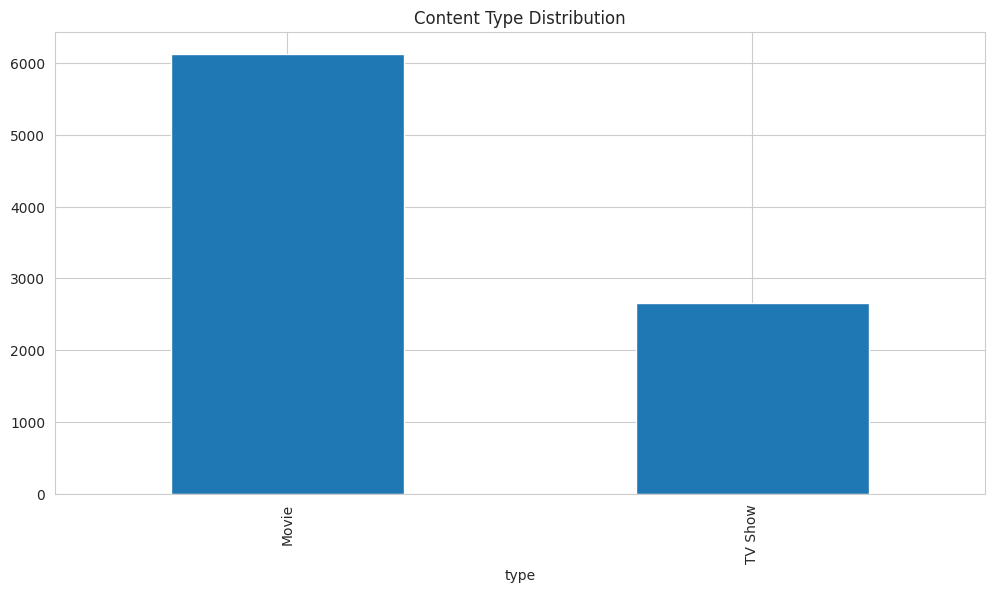

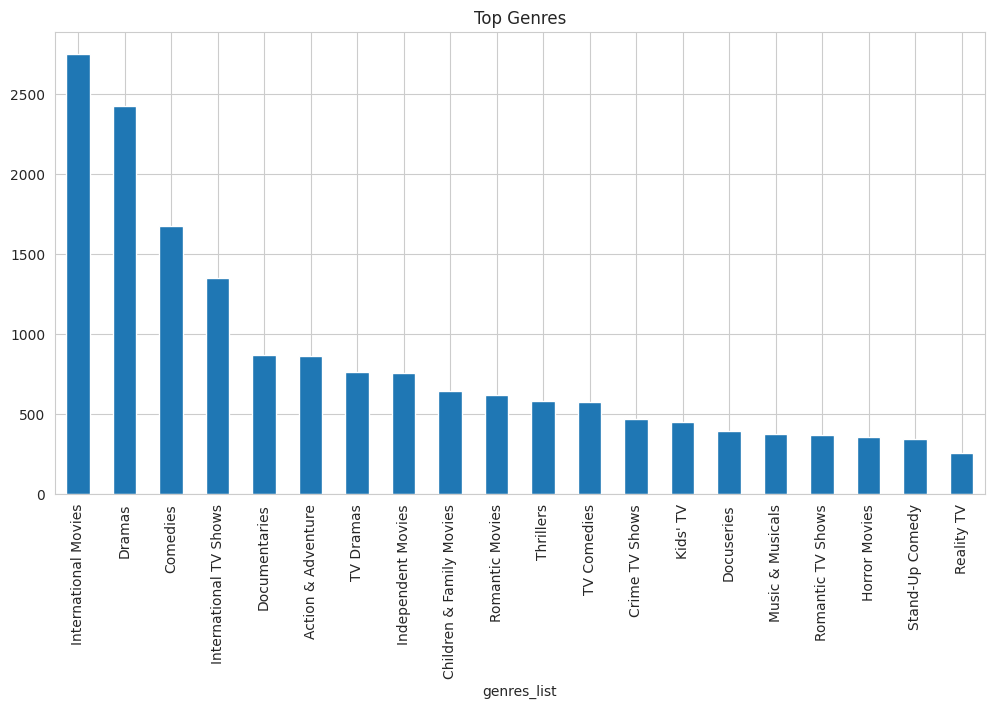

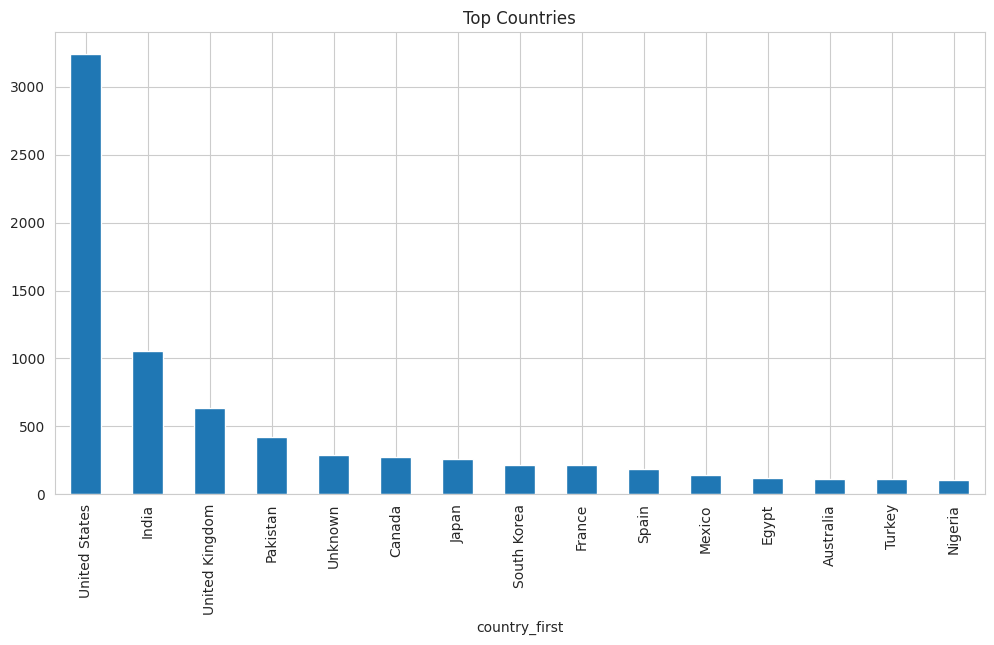

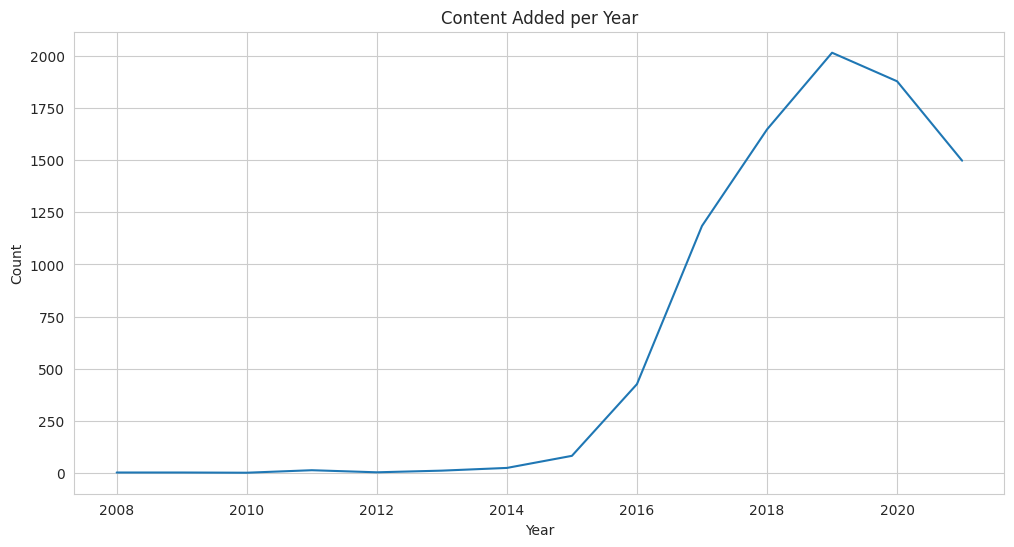

In [17]:
# Type distribution
df['type'].value_counts().plot(kind='bar', title='Content Type Distribution')
plt.show()

# Top genres
genres = df['genres_list'].explode()
genres.value_counts().head(20).plot(kind='bar', title='Top Genres')
plt.show()

# Top countries
df['country_first'].value_counts().head(15).plot(kind='bar', title='Top Countries')
plt.show()

# Content added per year
if 'year_added' in df.columns:
    df['year_added'].value_counts().sort_index().plot(title='Content Added per Year')
    plt.xlabel('Year'); plt.ylabel('Count')
    plt.show()


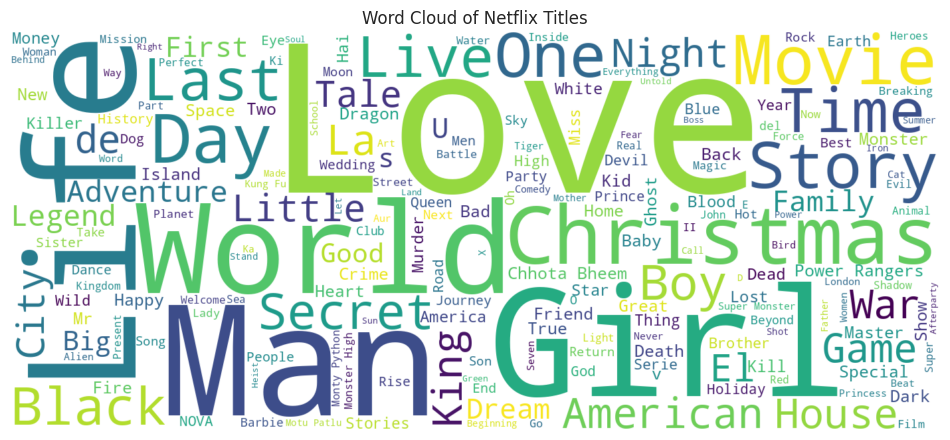

In [18]:
text = " ".join(df['title'].astype(str))
wc = WordCloud(width=1400, height=600, background_color='white').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Netflix Titles")
plt.show()


In [19]:
le_rating = LabelEncoder()
df['rating_enc'] = le_rating.fit_transform(df['rating_simpl'].astype(str))

le_type = LabelEncoder()
df['type_enc'] = le_type.fit_transform(df['type'].astype(str))

features = [
    'release_year','duration_int','num_genres','num_cast',
    'director_popularity','country_popularity','content_age',
    'title_len','title_word_count','desc_len','desc_word_count','desc_sentiment',
    'is_movie','has_multiple_genres','has_cast','rating_enc'
]

X = df[features].fillna(0)
y = df['type_enc']
print("Feature matrix:", X.shape)


Feature matrix: (8790, 16)


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (7032, 16) Test: (1758, 16)


In [21]:
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_type.classes_))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1225
     TV Show       1.00      1.00      1.00       533

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758



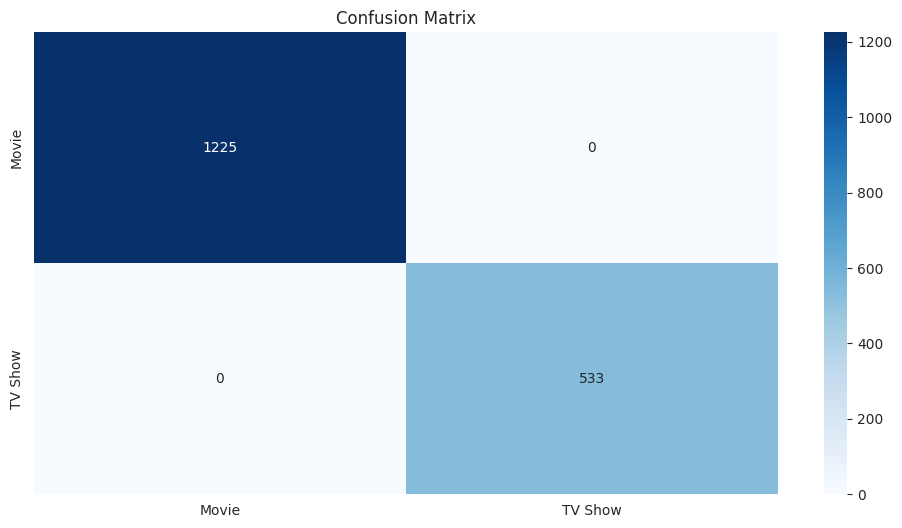

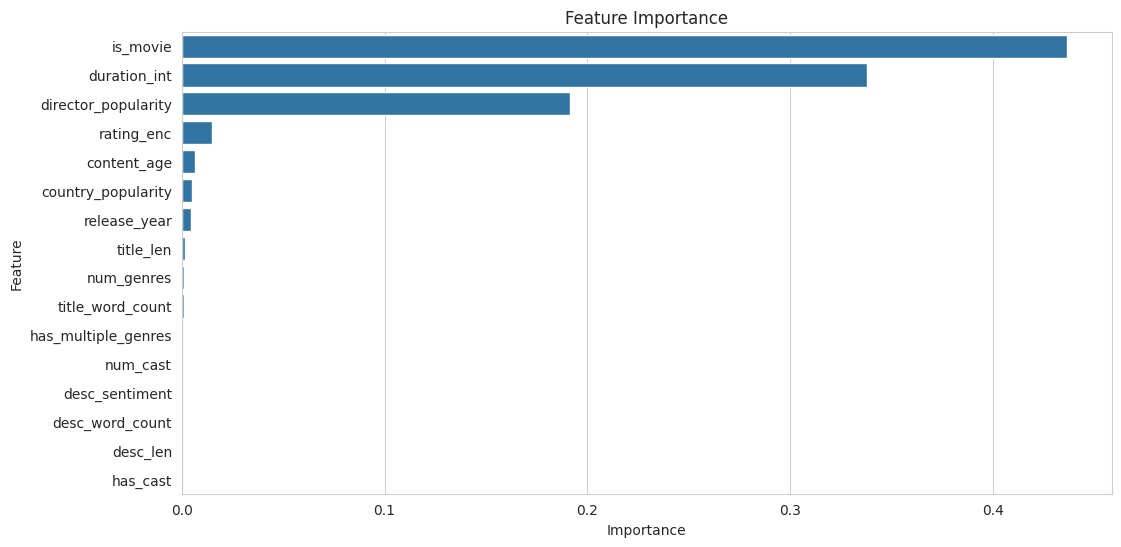

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_type.classes_, yticklabels=le_type.classes_)
plt.title('Confusion Matrix')
plt.show()

feat_imp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance')
plt.show()


In [24]:
# === Save cleaned dataset and model artifacts ===
import joblib
import os

# Save all files
df.to_csv("netflix_cleaned_advanced.csv", index=False)
joblib.dump(model, "netflix_rf_advanced.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(le_rating, "le_rating.joblib")
joblib.dump(le_type, "le_type.joblib")

print("✅ Cleaned data and model saved successfully!\n")

# === If running in Google Colab: create download links ===
try:
    from google.colab import files

    print("⬇️ Click below to download your files:")

    files.download("netflix_cleaned_advanced.csv")
    files.download("netflix_rf_advanced.joblib")
    files.download("scaler.joblib")
    files.download("le_rating.joblib")
    files.download("le_type.joblib")

except ImportError:
    # If not in Colab (e.g., Jupyter desktop)
    print("ℹ️ Not running in Google Colab, files saved locally in the current folder:")
    for file in [
        "netflix_cleaned_advanced.csv",
        "netflix_rf_advanced.joblib",
        "scaler.joblib",
        "le_rating.joblib",
        "le_type.joblib",
    ]:
        print("   •", os.path.abspath(file))


✅ Cleaned data and model saved successfully!

⬇️ Click below to download your files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>